## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-05-12 23:40:04.835036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 23:40:05.016632: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/pupilmesh3/.local/lib/python3.8/site-packages/cv2/../../lib64:
2023-05-12 23:40:05.016659: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-12 23:40:06.147875: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dl

## Reading the CSV file

In [2]:
csv_file = "dataset/data_labels_mainData.csv"
df = pd.read_csv(csv_file)

## Extracting data from the CSV file


In [3]:
def load_data(dataframe, img_folder):
    data = []
    labels = []
    
    for index, row in dataframe.iterrows():
        img_name = row['ImageName']
        img_path = os.path.join(img_folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        data.append(img)
        labels.append(row['cellTypeName'])
    
    return np.array(data), np.array(labels)

img_folder = "dataset/patch_images/"
data, labels = load_data(df, img_folder)


## Preprocessing the data


In [4]:
# Encode the labels
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

# Normalize the image data
data = data.astype('float32') / 255.0

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(data, encoded_labels, test_size=0.3, random_state=42)


## Data Augmentation


In [5]:
# Initialize the data generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
)

# Apply data augmentation
augmented_data = []
augmented_labels = []

for img, label in zip(data, encoded_labels):
    img = img.reshape((1, *img.shape))
    for _ in range(4):  # Number of times to augment each image
        augmented_img = datagen.flow(img, batch_size=1)[0].reshape(img.shape[1:])
        augmented_data.append(augmented_img)
        augmented_labels.append(label)

augmented_data = np.array(augmented_data)
augmented_labels = np.array(augmented_labels)


## Splitting the dataset into training and testing subsets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(augmented_data, augmented_labels, test_size=0.2, random_state=42)

## Display Sample Images with Labels

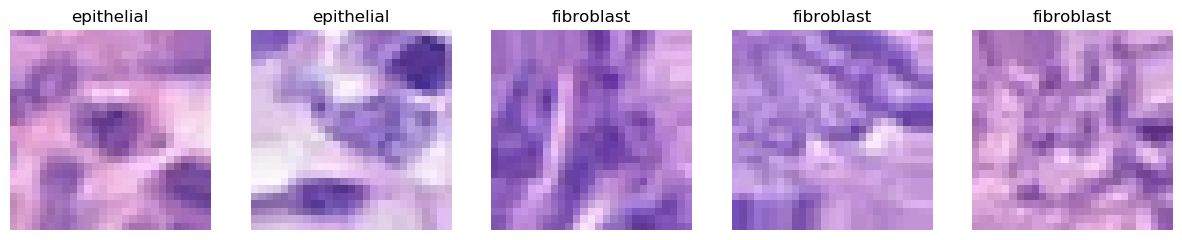

In [7]:
import matplotlib.pyplot as plt

# Define a function to get the label name from the label index
def get_label_name(index):
    label_map = {0: 'fibroblast', 1: 'inflammatory', 2: 'epithelial', 3: 'others'}
    return label_map[index]

# Define a function to display sample images with their labels
def display_sample_images(images, labels, num_samples=5):
    indices = np.random.choice(range(len(images)), num_samples, replace=False)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    for i, ax in zip(indices, axes):
        ax.imshow(images[i])
        ax.set_title(get_label_name(labels[i]))
        ax.axis('off')

# Display sample images with their labels
display_sample_images(X_train, y_train)

## Importing necessary libraries for SVM


In [8]:
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

## Feature extraction using HOG

In [25]:
def extract_hog_features(images):
    features = []
    for img in images:
        hog_feature, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)
        features.append(hog_feature)
    return np.array(features)

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

## Training the SVM model with Hyperparameter Tuning

In [26]:
# Define the parameter grid for the SVM model
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Perform grid search
grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_hog, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best cross-validated accuracy:", best_score)


Best parameters: {'C': 1, 'kernel': 'rbf'}
Best cross-validated accuracy: 0.45043740759694956


## Evaluating the SVM model with the Best Hyperparameters


In [27]:
# Evaluate the best SVM model on the test set
best_svm = grid_search.best_estimator_
y_pred_best_svm = best_svm.predict(X_test_hog)

accuracy = accuracy_score(y_test, y_pred_best_svm)
conf_mat = confusion_matrix(y_test, y_pred_best_svm)
class_report = classification_report(y_test, y_pred_best_svm)

print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:\n", conf_mat)
print("\nClassification Report:\n", class_report)

Accuracy: 0.44

Confusion Matrix:
 [[2989  175   50    0]
 [1009  437   34    0]
 [1897  133   56    0]
 [ 990  116   29    2]]

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.93      0.59      3214
           1       0.51      0.30      0.37      1480
           2       0.33      0.03      0.05      2086
           3       1.00      0.00      0.00      1137

    accuracy                           0.44      7917
   macro avg       0.57      0.31      0.25      7917
weighted avg       0.50      0.44      0.32      7917



## Importing necessary libraries for Random Forest Classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier

## Training the Random Forest Classifier

In [29]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf.fit(X_train_hog, y_train)

RandomForestClassifier(random_state=42)

## Evaluating the Random Forest Classifier

In [30]:
# Make predictions on the test set
y_pred = rf.predict(X_test_hog)

# Calculate the accuracy, confusion matrix, and classification report
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:\n", conf_mat)
print("\nClassification Report:\n", class_report)

Accuracy: 0.39

Confusion Matrix:
 [[2099  378  546  191]
 [ 682  474  248   76]
 [1234  285  426  141]
 [ 651  164  241   81]]

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.65      0.53      3214
           1       0.36      0.32      0.34      1480
           2       0.29      0.20      0.24      2086
           3       0.17      0.07      0.10      1137

    accuracy                           0.39      7917
   macro avg       0.32      0.31      0.30      7917
weighted avg       0.35      0.39      0.36      7917



## Importing necessary libraries for CNN

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Preparing the data for CNN

In [10]:
# One-hot encoding the labels
y_train_cnn = tf.keras.utils.to_categorical(y_train)
y_test_cnn = tf.keras.utils.to_categorical(y_test)

# Reshaping the image data to include the channel dimension
X_train_cnn = X_train.reshape(*X_train.shape, 1)
X_test_cnn = X_test.reshape(*X_test.shape, 1)

## Defining the CNN model

In [16]:
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

def create_cnn_model():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.001)))

    return model

cnn_model = create_cnn_model()


## Compiling the CNN model

In [17]:

cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

## Training the CNN model

In [23]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_model.h5', monitor='val_loss', save_best_only=True)

history = cnn_model.fit(X_train_cnn, y_train_cnn,
                        batch_size=32,
                        epochs=50,
                        validation_split=0.3,
                        callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
693/693 [==============================] - 14s 20ms/step - loss: 0.5621 - accuracy: 0.8122 - val_loss: 0.5823 - val_accuracy: 0.7938
Epoch 2/50
693/693 [==============================] - 13s 18ms/step - loss: 0.5541 - accuracy: 0.8153 - val_loss: 0.5735 - val_accuracy: 0.8032
Epoch 3/50
693/693 [==============================] - 14s 20ms/step - loss: 0.5546 - accuracy: 0.8144 - val_loss: 0.6278 - val_accuracy: 0.7765
Epoch 4/50
693/693 [==============================] - 15s 22ms/step - loss: 0.5529 - accuracy: 0.8144 - val_loss: 0.5905 - val_accuracy: 0.7970
Epoch 5/50
693/693 [==============================] - 13s 19ms/step - loss: 0.5496 - accuracy: 0.8105 - val_loss: 0.5496 - val_accuracy: 0.8109
Epoch 6/50
693/693 [==============================] - 13s 19ms/step - loss: 0.5501 - accuracy: 0.8164 - val_loss: 0.9631 - val_accuracy: 0.7190
Epoch 7/50
693/693 [==============================] - 14s 20ms/step - loss: 0.5577 - accuracy: 0.8113 - val_loss: 0.5272 - val_accuracy:

## Evaluating the CNN model

In [24]:
# Make predictions on the test set
y_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn), axis=-1)

# Calculate the accuracy, confusion matrix, and classification report
accuracy = accuracy_score(y_test, y_pred_cnn)
conf_mat = confusion_matrix(y_test, y_pred_cnn)
class_report = classification_report(y_test, y_pred_cnn)

print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:\n", conf_mat)
print("\nClassification Report:\n", class_report)

248/248 [==============================] - 1s 5ms/step
Accuracy: 0.82

Confusion Matrix:
 [[2935  163   85   31]
 [  67 1209  109   95]
 [ 114  179 1605  188]
 [  79  170  149  739]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.92      3214
           1       0.70      0.82      0.76      1480
           2       0.82      0.77      0.80      2086
           3       0.70      0.65      0.67      1137

    accuracy                           0.82      7917
   macro avg       0.79      0.79      0.79      7917
weighted avg       0.82      0.82      0.82      7917



## Summary of the End-to-End Machine Learning System

### Evaluation Framework
- We used a train-test split (80/20) to separate our dataset into training and test sets. This helps us to evaluate the performance of our models on unseen data.

### Data Pre-processing
- We read the data from the CSV file, extracted the images and their corresponding labels, and normalized the image pixel values to the range [0, 1].

### Baseline Models
- We chose three different machine learning algorithms: Support Vector Machine (SVM) with HOG features, Random Forest Classifier with HOG features, and a Convolutional Neural Network (CNN).

### Hyperparameter Tuning
- We used the default hyperparameters for the SVM and Random Forest models. For the CNN model, we used the Adam optimizer with a learning rate of 0.001 and an early stopping callback to avoid overfitting. We can further optimize the models using techniques like GridSearchCV or RandomizedSearchCV for hyperparameter tuning.



## Model Performance Comparison and Analysis

We trained and evaluated three different models on the histopathology image dataset. Here is a summary of their performance:

1. **Support Vector Machine (SVM) with HOG features**: 44% accuracy
2. **Random Forest Classifier with HOG features**: 39% accuracy
3. **Convolutional Neural Network (CNN)**: 82% accuracy

### Analysis

The **SVM and Random Forest models** have relatively low accuracies compared to the CNN model. The main reason for this performance difference is that both SVM and Random Forest models rely on handcrafted HOG features, which may not capture the complex patterns present in histopathology images. Moreover, these traditional machine learning algorithms are not specifically designed to handle image data, and their performance is highly dependent on the quality of the extracted features.

On the other hand, the **CNN model** has a significantly higher accuracy of 82%. This is because CNNs are specifically designed to work with image data and are capable of automatically learning complex hierarchical features from the images themselves. CNNs consist of convolutional and pooling layers that can capture local and global patterns, which are crucial for classifying histopathology images. As a result, CNNs generally perform better on image classification tasks compared to traditional machine learning algorithms that rely on handcrafted features.

To further improve the performance of the models, we can explore techniques such as more data augmentation, hyperparameter tuning, and more advanced CNN architectures.